### Import Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import xgboost as xgb
from scipy.stats import uniform, randint

### Read Data

In [2]:
data = pd.read_excel(r"D:/python projects/read_files/dataset.xlsx")

#### General Column Handling

In [3]:
data.columns = data.columns.str.replace(' ','')
data.columns = data.columns.str.lower()

#### Specifies features and target

I will specify the features which are the mental health issues category, also the target which is iamunemployed which i will rename as employed to easier the calling

In [4]:
data = data[['lackofconcentration', 'anxiety', 'depression', 'obsessivethinking',
        'moodswings', 'panicattacks', 'compulsivebehavior', 'tiredness', 'age',
        'gender', 'householdincome','iamunemployed']]

In [5]:
data.rename(columns = {'iamunemployed' : 'unemployed'},inplace=True)

In [6]:
data.head(5)

,lackofconcentration,anxiety,depression,obsessivethinking,moodswings,panicattacks,compulsivebehavior,tiredness,age,gender,householdincome,unemployed
0,1.0,1,1,1.0,0.0,1.0,0.0,0.0,30-44,Male,"$25,000-$49,999",1
1,1.0,1,1,0.0,0.0,1.0,0.0,1.0,18-29,Male,"$50,000-$74,999",0
2,0.0,0,0,0.0,0.0,0.0,0.0,0.0,30-44,Male,"$150,000-$174,999",0
3,0.0,0,0,0.0,0.0,0.0,0.0,0.0,30-44,Male,"$25,000-$49,999",1
4,1.0,1,1,1.0,1.0,1.0,1.0,1.0,30-44,Male,"$25,000-$49,999",0


In [7]:
data.shape

(334, 12)

#### Null Checking

I will check missing values and if they exist i will impute them with median if their dtypes is numerical or  most frequent if their dtype is numerical

In [8]:
data.isnull().sum()

lackofconcentration    1
anxiety                0
depression             0
obsessivethinking      1
moodswings             1
panicattacks           1
compulsivebehavior     1
tiredness              1
age                    0
gender                 0
householdincome        0
unemployed             0
dtype: int64

In [9]:
def fillna(df):
    for column in df.columns:
        if df[column].dtype == object:
            simo = SimpleImputer(strategy='most_frequent')
            df[column] = simo.fit_transform(df[column].values.reshape(-1,1))
        else:
            sime = SimpleImputer(strategy='median')
            df[column] = sime.fit_transform(df[column].values.reshape(-1,1))
            
fillna(data)

#### Checking duplicated records

I will check for duplications

In [10]:
data.duplicated().sum()

87

In [11]:
data.drop_duplicates(keep=False,inplace=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 333
Data columns (total 12 columns):
lackofconcentration    199 non-null float64
anxiety                199 non-null float64
depression             199 non-null float64
obsessivethinking      199 non-null float64
moodswings             199 non-null float64
panicattacks           199 non-null float64
compulsivebehavior     199 non-null float64
tiredness              199 non-null float64
age                    199 non-null object
gender                 199 non-null object
householdincome        199 non-null object
unemployed             199 non-null float64
dtypes: float64(9), object(3)
memory usage: 20.2+ KB


In [13]:
data.describe()

,lackofconcentration,anxiety,depression,obsessivethinking,moodswings,panicattacks,compulsivebehavior,tiredness,unemployed
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,0.246231,0.457286,0.396985,0.201005,0.180905,0.236181,0.135678,0.407035,0.351759
std,0.431901,0.499429,0.490507,0.401763,0.385910,0.425806,0.343310,0.492521,0.478723
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


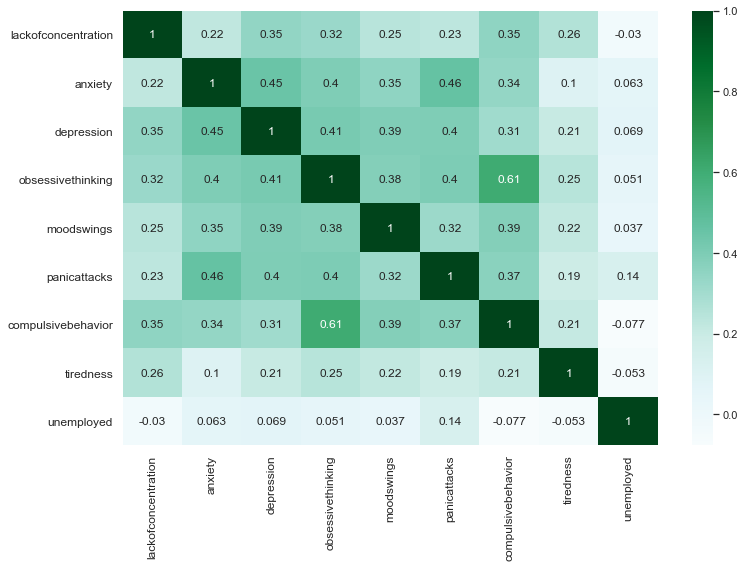

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(),annot=True,annot_kws={'size':12},cmap="BuGn")
plt.tick_params(labelsize=12)

#### Specifying top 5th features and target

I will specify top 5th features and target

In [15]:
data = data[['panicattacks','compulsivebehavior',
             'depression', 'anxiety',
             'tiredness','unemployed'
             ]]

#### Create dataframe for classification later

I will make copy of data before i scale it so i don't need to work twice on preparing again. This will be used for the final result conlusion and classification

In [16]:
cat_data = data.copy()
final_data = data.copy()

### Cluster Model Building

#### PCA to optimize DBSCAN

In [17]:
scp = StandardScaler()
data = scp.fit_transform(data)

pca = PCA(n_components=1)
pca = pca.fit(data)
pca_data = pca.transform(data)

#### DBSCAN PCA Fitting

In [18]:
dbscan = DBSCAN(eps=0.3, min_samples = np.log(data.shape[0]))
dbc_pca = dbscan.fit_predict(pca_data)

#### DBSCAN Base Model

In [19]:
dbc = dbscan.fit_predict(data)

### Cluster Evaluation

I will compare how good PCA outperform the base model without PCA

In [20]:
def validate(X,model):
    s_metrics = metrics.silhouette_score(X, model)
    dbi_metrics = metrics.davies_bouldin_score(X, model)
    print('Silhouette score : %s'%s_metrics)
    print('DBI score : %s'%dbi_metrics)

In [21]:
validate(data,dbc)

Silhouette score : 0.6076747440544061
DBI score : 1.0150160897985485


In [22]:
validate(pca_data,dbc_pca)

Silhouette score : 0.750866715857714
DBI score : 0.3059602855691396


### Classification Model Building 

In [23]:
cat_data['cluster'] = dbc_pca

In [24]:
cat_data.columns

Index(['panicattacks', 'compulsivebehavior', 'depression', 'anxiety',
       'tiredness', 'unemployed', 'cluster'],
      dtype='object')

In [25]:
cat_data = pd.get_dummies(cat_data,columns=['panicattacks', 'compulsivebehavior', 'depression', 'anxiety',
       'tiredness'])

#### Plot Correlations

Before i really build the model i'd like to see how related my features towards my target, which is not that bad

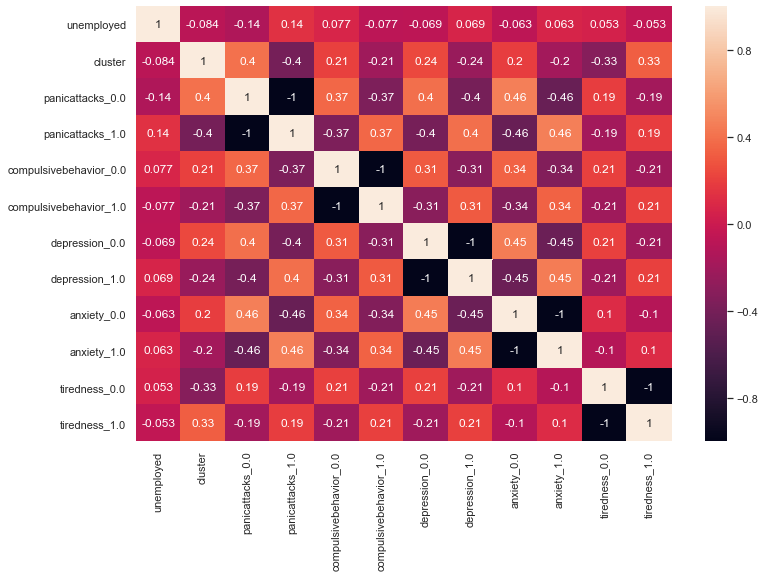

In [26]:
corrdf = pd.get_dummies(cat_data).corr()
plt.figure(figsize=(12,8))
sns.heatmap(pd.get_dummies(cat_data).corr(),annot=True)

In [27]:
X = np.array(cat_data.drop(['unemployed'],1))
y = np.array(cat_data['unemployed'])

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


### XGBClassifier Hyperparameter Tuning with GridSearchCV + Fitting

In [28]:
xgb_model = xgb.XGBClassifier()
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [5, 10, 20 ,30],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [10, 20, 50],
        'learning_rate': [0.01,0.02,0.1,0.3]
}

grid = GridSearchCV(estimator= xgb_model,param_grid =params,
                    refit=True,verbose=1,cv =10,n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 10 folds for each of 1296 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1232 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 3232 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 6032 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 9632 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 12960 out of 12960 | elapsed:  1.5min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [5, 10, 20, 30],
                         'learning_rate': [0.01, 0.02, 0.1, 0.3],

### XGBClassifier Base Model

In [29]:
xgb_base_model = xgb.XGBClassifier()
xgb_base_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Classification Model Evaluation

I will compare the performance of my regularized XGBClassifier model with base XGBClassifier model

In [30]:
def evaluate(model,X_train,y_train,X_test,y_test):
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print('Training set score : %s'%model.score(X_train,y_train))
    print('Test set score : %s'%model.score(X_test,y_test))
    print('Accuracy score : %s'%accuracy)

In [31]:
best_param = grid.best_estimator_
evaluate(best_param,X_train,y_train,X_test,y_test)

Training set score : 0.6729559748427673
Test set score : 0.55
Accuracy score : 0.55


In [32]:
print(best_param)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)


In [33]:
evaluate(xgb_base_model,X_train,y_train,X_test,y_test)

Training set score : 0.6855345911949685
Test set score : 0.525
Accuracy score : 0.525


### Conclusion

### 1. Plot Unemployed Based On Clusters

In [34]:
y_pred = best_param.predict(X_test)

In [35]:
unemployed_new = np.append(y_train,y_pred)

In [36]:
final_data = final_data.assign(unemployed=unemployed_new)
final_data['cluster'] = dbc_pca

In [37]:
final_data['unemployed'] = final_data['unemployed'].replace(to_replace=[1.0,0.0],value=['yes','no'])

#### Plotting counts of each cluster
This shows that top 3 clusters with most numbers are cluster 2,4,5

Text(0.5, 1.0, 'Counts of each cluster')

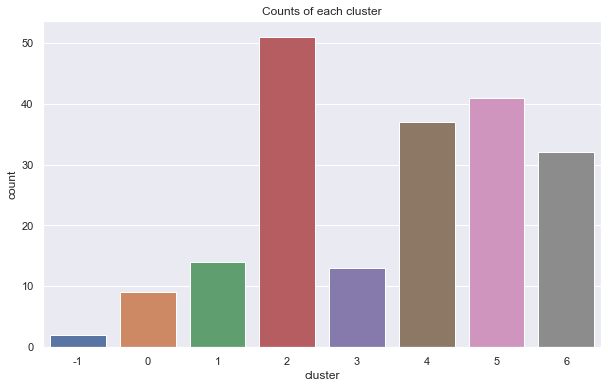

In [38]:
plt.figure(figsize=(10,6))
sns.countplot(x = final_data['cluster'],data = final_data)
plt.title('Counts of each cluster')

#### Plotting Unemployed yes vs Unemployed no in each cluster
This shows the top 3 clusters with the most unemployed status, which are cluster 2,5,4 and that is shows that the numbers of unemployed and the employed has significant different. I could see that most people are employed in every clusters so this implies that mental health issues don't stop someone to be unemployed 

Text(0.5, 1.0, 'Unemployed yes vs Unemployed no in each cluster')

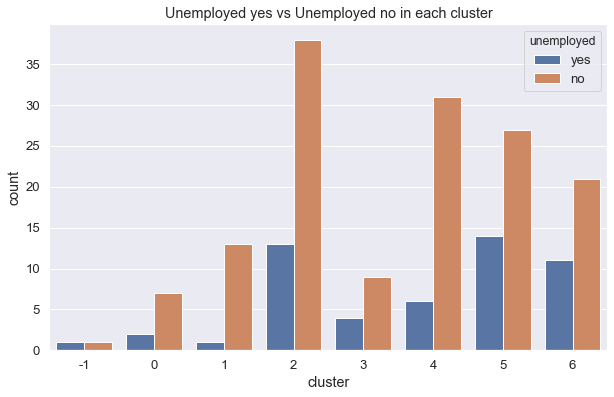

In [39]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.2)
sns.countplot(x="cluster", hue="unemployed", data=final_data)
plt.title('Unemployed yes vs Unemployed no in each cluster')

#### Plotting Unemployed yes vs Unemployed no in general
From the plot i could learn that people with mental health issues still have high chances to be employed so it does not effect employment much by still having 70,85% to be employed which means again,having mental health issues don't stop someone to be unemployed 

Text(0.5, 1.0, 'Unemployed yes vs Unemployed no in general')

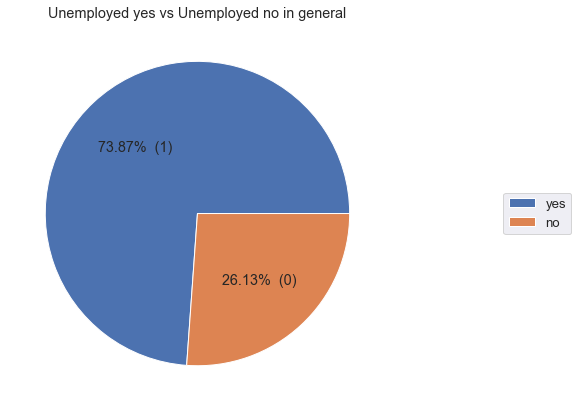

In [40]:
plt.figure(figsize=(7,7))
sns.set(font_scale=1.2)
plt.pie(final_data.groupby(['unemployed'])['unemployed'].count(),
        autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(corrdf['unemployed'])/100))
plt.legend(final_data['unemployed'].unique(),loc='center right',
            bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Unemployed yes vs Unemployed no in general')

#### Plotting Combinations of mental health issues in each cluster

From my clusters of people who are unemployed it shows the combination of the mental health issues, it seems cluster 2 and 6 don't have any mental heath issues at all. And people in cluster 4 and cluster 3 seems to have all mental health issues significancy.

Text(0.5, 1.0, 'Combinations of mental health issues in each cluster')

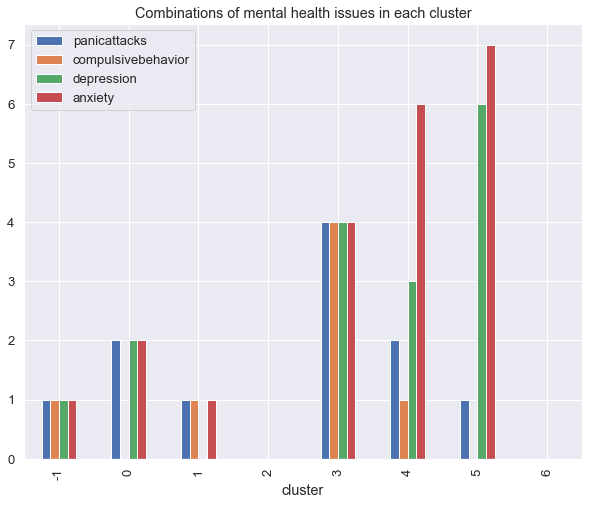

In [41]:
unemployed = final_data.iloc[:,np.r_[0:4,-2:0]][final_data['unemployed']=='yes']
unemployed = unemployed.groupby(['cluster'])['panicattacks', 'compulsivebehavior', 'depression', 'anxiety'].sum()
unemployed.plot.bar(figsize=(10,8))
plt.title('Combinations of mental health issues in each cluster')

### 2. Model Conclusion

1. **Clustering Model :**  The clustering model which is optimized by PCA outperforms the model without PCA optimization. PCA is very useful for data with many features. It's well known to help us to tackle the curse of dimension issue since many of the real world dataset would likely have dozens of features. From this experiment, i could see that it's also handy for small data. From this kernel the higher Silhouette Coefficient the better the model defines the clusters. While the DBI score if the values closer to zero the better partition or separation between the clusters we have. In this kernel we see that the DBSCAN with PCA outperforms 15% from the base model for the Silhouette score. And the DBI score outperforms 70% from the base model.
2. **Classsification Model :**  The classification model which is optimized by GridSearchCV outperforms the base model 0.025%. That's okay since hyperparameter tuning needs a lot of trials and errors. But the important point is with optimization. Model could learn better.